In [109]:
import re
import PIL
import torch
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import resnet50_ft_dims_2048 as model
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE

In [110]:
mean = (131.0912, 103.8827, 91.4953)
batch_size = 10

def load_data(path='', shape=None):
    short_size = 224.0
    crop_size = shape
    img = PIL.Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=PIL.Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean
    return x


def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
        
def initialize_model():
    # Currently, it's cpu mode.
    network = model.resnet50_ft(weights_path='resnet50_ft_dims_2048.pth')
    network.eval()
    return network

def image_encoding(model, facepaths):
    print('==> compute image-level feature encoding.')
    num_faces = len(facepaths)
    face_feats = np.empty((num_faces, 2048))
    imgpaths = facepaths
    imgchunks = list(chunks(imgpaths, batch_size))

    for c, imgs in enumerate(imgchunks):
        im_array = np.array([load_data(path=i, shape=(224, 224, 3)) for i in imgs])
        f = model(torch.Tensor(im_array.transpose(0, 3, 1, 2)))[1].detach().cpu().numpy()[:, :, 0, 0]
        start = c * batch_size
        end = min((c + 1) * batch_size, num_faces)
        # This is different from the Keras model where the normalization has been done inside the model.
        face_feats[start:end] = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True))
        if c % 50 == 0:
            print('-> finish encoding {}/{} images.'.format(c * batch_size, num_faces))
    return face_feats


In [112]:
facepaths = gb.glob('morphs/*.png')
model_eval = initialize_model()
face_feats = image_encoding(model_eval, facepaths)

==> compute image-level feature encoding.
-> finish encoding 0/120 images.


In [121]:
regex = re.compile(r'\d+')
labels = np.array([int(regex.findall(facepath)[0]) for facepath in facepaths])

# PCA

In [117]:
pca = decomposition.PCA()

shape of pca_reduced.shape =  (120, 2)


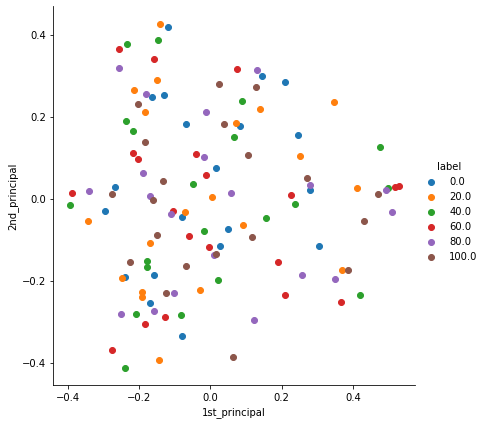

In [118]:
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(face_feats)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, labels)).T
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

# t-SNE

/home/osho/anaconda3/envs/dl/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


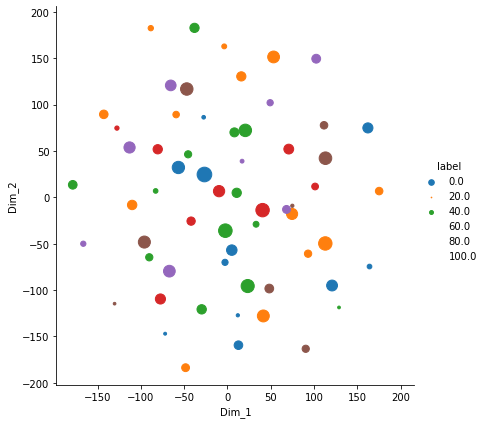

In [119]:
model = TSNE(n_components=3, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(face_feats)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",  "Dim_3", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2', 'Dim_3').add_legend()
plt.show()

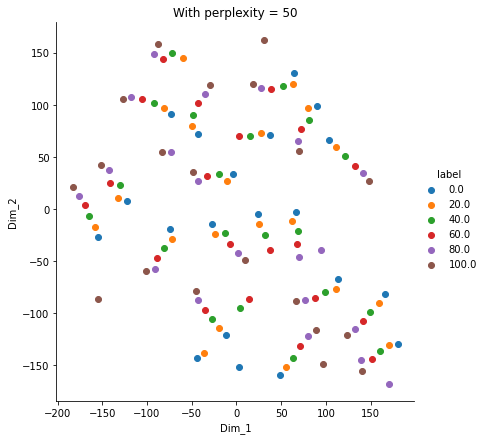

In [120]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(face_feats)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

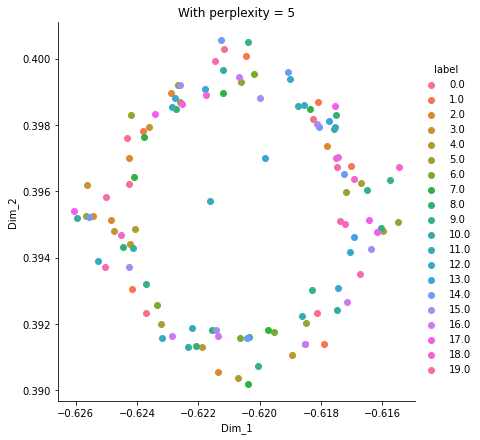

In [122]:
model = TSNE(n_components=2, random_state=0, perplexity=120)
tsne_data = model.fit_transform(face_feats)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

In [96]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
reduced = pca.fit_transform(face_feats)

reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

In [97]:
# hyperparameters
ellipside = False
image_names = facepaths
no_of_images = len(facepaths)
image_width = 120

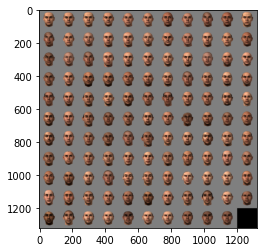

In [98]:
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()
merged_image = Image.fromarray(merged_image)
merged_image.save('merged.png');
# merged_image.save('../merged-%s.png'%image_path.split('/')[-2])